<a href="https://colab.research.google.com/github/mbaltieri/lstmTest/blob/master/LstmTestColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch  0 MSE:  17277.75136346301
Epoch  100 MSE:  524.5177435338582
Epoch  200 MSE:  371.2706230475553
Epoch  300 MSE:  288.4015642524304
Epoch  400 MSE:  230.80627209160335
Epoch  500 MSE:  189.05487641738898
Epoch  600 MSE:  157.6498697989598
Epoch  700 MSE:  133.01891580321603
Epoch  800 MSE:  112.93835937301031
Epoch  900 MSE:  95.96614450151671
Epoch  1000 MSE:  80.91942210882948


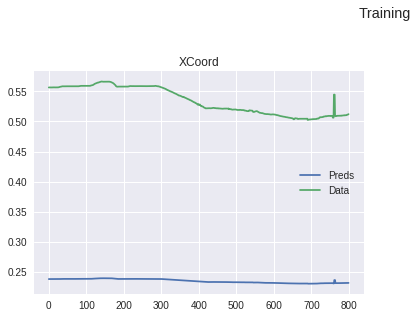

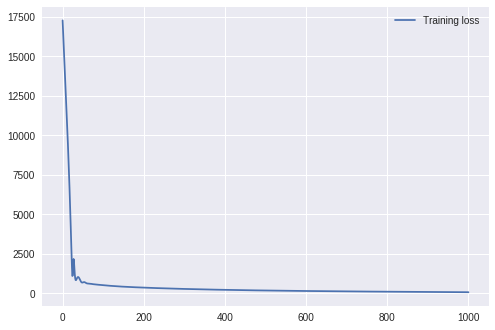

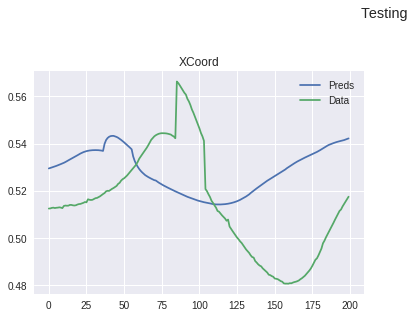

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 19 16:35:04 2019

Pre-packaged LSTM from Pytorch

@author: mb540
"""

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# Global
torch.set_default_dtype(torch.float64)
device = torch.device("cuda:0") # Uncomment this to run on GPU

# Network
learning_rate = 1e-3
epochs = 1000
input_size = 1
output_size = 1
sequence_length = 50
hidden_size = 64

# Training
num_datapoints = 1000
test_size = 0.2
num_train = int((1-test_size) * num_datapoints)

#####################
# Read data from file
######################
df = pd.read_csv('https://raw.githubusercontent.com/mbaltieri/lstmTest/master/Pre-processed_data.csv')

# Remove motor data from output (we don't want to predict motor commands)
df_output = df.drop(['LMotor', 'RMotor'], 1)
df_output = df_output.drop(['YCoord', 'XOrient', 'YOrient'], 1)
df = df_output

input_size = len(df.columns)                    # recompute input and output size after the data is read
output_size = len(df_output.columns)

# Give a window of lenght sequence_length
X = torch.zeros(sequence_length,0,input_size)
y = torch.zeros(sequence_length,0,output_size)
for i in range(1,num_datapoints+1):
    X = torch.cat((X, torch.tensor(df[i-1:i-1+sequence_length].values).view([sequence_length,1,input_size])),1)
    y = torch.cat((y, torch.tensor(df_output[i:i+sequence_length].values).view([sequence_length,1,output_size])),1)

X_train = X[:, :num_train, :]
X_test = X[:, num_train:num_datapoints, :]

y_train = y[:, :num_train, :]
y_test = y[:, num_train:num_datapoints, :]

# Format input sets for pytorch lstm
X_train = X_train.view([sequence_length, -1, input_size])
X_test = X_test.view([sequence_length, -1, input_size])

# Create lstm
lstm = torch.nn.LSTM(input_size, hidden_size)
# Create loss function
loss_fn = torch.nn.MSELoss(size_average=False)
# Choose optimisation method
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
# Create array for saving training error
hist = np.zeros(epochs+1)

# Stick to Pytorch language in the future? batch_size = num_train

# Reduce dimensions to match output_size (to check)
linear = torch.nn.Linear(hidden_size, output_size)

for t in range(epochs+1):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    # lstm.hidden = lstm.init_hidden()
    
    # Forward pass
    lstm_out, lstm_hidden = lstm(X_train)

    y_pred = linear(lstm_out.view(sequence_length, num_train, -1))

    loss = loss_fn(y_pred, y_train)
    if t % 100 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()


#####################
# Test network
#####################
# X_test = torch.rand(10,num_datapoints-num_train,1)
lstm_out_test, lstm_hidden_test = lstm(X_test)
y_pred_test = linear(lstm_out_test[-1].view(num_datapoints-num_train, -1))

#####################
# Plot preds and performance (training and testing)
#####################

# Training
plt.figure(figsize=(13,9))
plt.suptitle('Training')
plt.subplot(2,2,1)
plt.plot(y_pred[0,:,0].detach().numpy(), label="Preds")
plt.plot(y_train[0,:,0].detach().numpy(), label="Data")
plt.title('XCoord')
plt.legend()
# plt.subplot(2,2,2)
# plt.plot(y_pred[:,1].detach().numpy(), label="Preds")
# plt.plot(y_train[:,1].detach().numpy(), label="Data")
# plt.title('YCoord')
# plt.legend()
# plt.subplot(2,2,3)
# plt.plot(y_pred[:,2].detach().numpy(), label="Preds")
# plt.plot(y_train[:,2].detach().numpy(), label="Data")
# plt.title('XOrient')
# plt.legend()
# plt.subplot(2,2,4)
# plt.plot(y_pred[:,3].detach().numpy(), label="Preds")
# plt.plot(y_train[:,3].detach().numpy(), label="Data")
# plt.title('YOrient')
plt.legend()

plt.figure()
plt.plot(hist, label="Training loss")
plt.legend()


# Testing
plt.figure(figsize=(13,9))
plt.suptitle('Testing')
plt.subplot(2,2,1)
plt.plot(y_pred_test[:,0].detach().numpy(), label="Preds")
plt.plot(y_test[0,:,0].detach().numpy(), label="Data")
plt.title('XCoord')
plt.legend()
# plt.subplot(2,2,2)
# plt.plot(y_pred_test[:,1].detach().numpy(), label="Preds")
# plt.plot(y_test[:,1].detach().numpy(), label="Data")
# plt.title('YCoord')
# plt.legend()
# plt.subplot(2,2,3)
# plt.plot(y_pred_test[:,2].detach().numpy(), label="Preds")
# plt.plot(y_test[:,2].detach().numpy(), label="Data")
# plt.title('XOrient')
# plt.legend()
# plt.subplot(2,2,4)
# plt.plot(y_pred_test[:,3].detach().numpy(), label="Preds")
# plt.plot(y_test[:,3].detach().numpy(), label="Data")
# plt.title('YOrient')
# plt.legend()

# plt.figure()
# plt.plot(X[-1].detach().numpy())
# plt.plot(X_train[-1].detach().numpy())
# plt.plot(X_test[-1].detach().numpy())
# a=torch.cat((X_train,X_test),1)
# plt.plot(a[-1].detach().numpy())

plt.show()